In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops,loopInterpolate,tailUpMs2,DespondsMs2Loops
from autocorrelationDataProcessing import tracePackageAutocorrelation
from autocorrelationAnalyticInference import fitAutocorrelationFunction

In [3]:
# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0137
k_off = 0.0139
duration = 400   # seconds
num = 100           # number of traces in our simulated dataset

loop_function = SnailPromoterMs2Loops().loop_function

In [4]:
stepsize

3.8

In [5]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [6]:
tracelist = tracePackage.tracelist
len(tracelist[1])

80

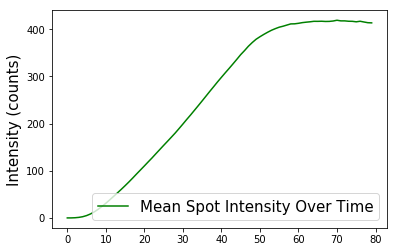

In [7]:
plt.plot(np.mean(tracelist, axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [8]:
# define start and stop indeces
start_index = 50
stop_index = -1

In [9]:
autopackage = tracePackageAutocorrelation(tracelist, loop_function, start_index, stop_index)

In [10]:
t = np.arange(len(autopackage.tracelist[1][1:]))

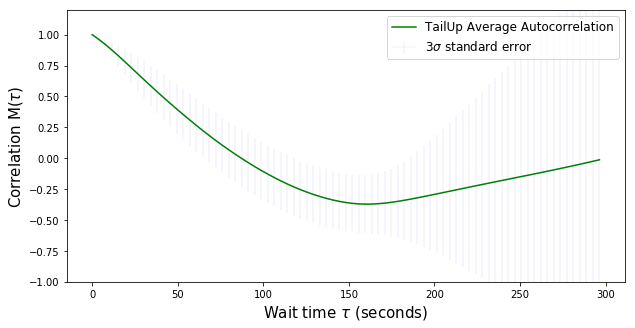

In [11]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
autoav = autopackage.autoav
autostd = autopackage.auto_err
avgflors = autopackage.avgflors

ax.plot(t*stepsize, autoav, color = 'g', label = "TailUp Average Autocorrelation")
ax.errorbar(x=t*stepsize, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'3$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

In [12]:
# fit for pon in a SIMPLE way
def fitPon(autopackage, loop_function):
    avg_flors = autopackage.avgflors
    pon = np.mean(avg_flors / np.sum(loop_function)) 
    pon_std = np.std(avg_flors/ np.sum(loop_function)) 

    return pon,pon_std

In [13]:
pon,pstd = fitPon(autopackage, loop_function)
print(pon)

0.48155957667958044


In [14]:
fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)

Pon                       =  0.4815595766795806
k_on + k_off              =  0.024041724058522347 s^-1
k_on                      =  0.01157752246026931
k_off                     =  0.012464201598253037
t_polII_block             =  6 seconds
characteristic timescale  =  41.59435477945761 seconds
covariance                =  3.8103819277311696e-06


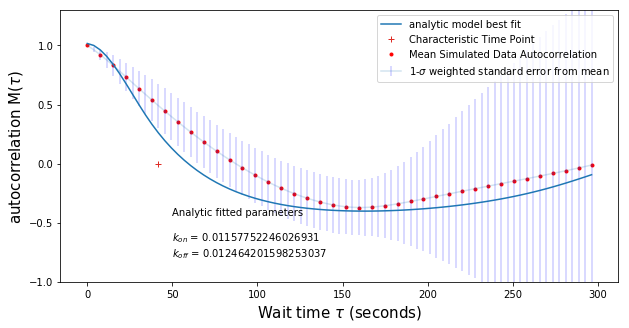

In [15]:
kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=True, 
                                                                                   upperbound=0.1, lowerbound=0.001,fitpon=True)

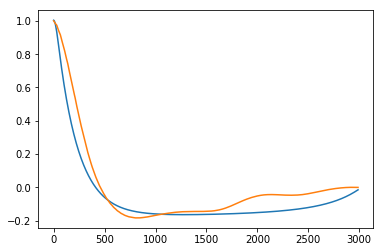

In [15]:
plt.plot(t*stepsize, fitAutoPack.autocorrFunc(t*stepsize, 1/34))
plt.plot(t*stepsize, autoav)

In [19]:
# something to plot with
t = np.arange(len(autoav))

AttributeError: 'fitAutocorrelationFunction' object has no attribute 'autocorrAnalytic'

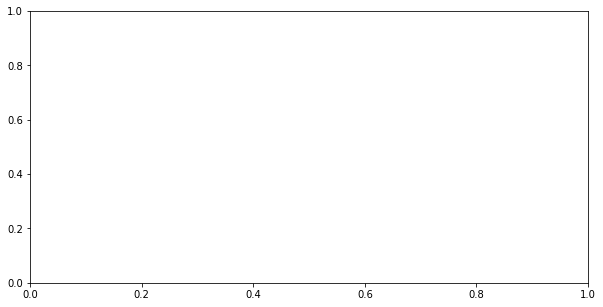

In [18]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)

ax.plot(t, fitAutoPack.autocorrAnalytic(t,1/chrtime), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t[::15],autoav[::15], marker='.', 
                   color='r', label = 'mean tUp simulated data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t, y=autoav, yerr=(weightstd*2, weightstd*2), 
                        ecolor='b', alpha=0.2, label = r'2-$\sigma$ weighted standard error from mean')  

#plt.plot(chrtime, 1/(np.e), size=20, color='r')
plt.legend(loc="best")
ax.set_ylim(-1, 1.3)
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'autocorrelation M($\tau$)', fontsize=15)
#plt.text(x=0.07, y=-1.8, 
             #s='Simulated Parameters \n\n$k_{on}$ =' + str(k_on) +
                    # '\n$k_{off}$ = ' + str(k_off) +  '\n$k_{elong}$ = '+ str(k_elong) 
                             #+ ' bp/sec \nobservation time = '+ str(stepsize) + ' seconds')
plt.text(x=50, y=-.8, s='Analytic fitted parameters \n\n$k_{on}$ = ' 
                                 + str(kon_fit) + '\n$k_{off}$ = ' + str(koff_fit))
plt.show()

In [19]:
np.linalg.eig(pcov)

(array([4.15360676e-07]), array([[1.]]))

In [20]:
# some tricks to get info we need to plot an ellipse, aligned with # some t 
#    the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(pcov)
angle = np.degrees(np.arctan2(eigvec[0,0], eigvec[0,0]))
w = 2*np.sqrt(eigval)
h=0

In [21]:
w

array([0.00128897])

In [22]:
pars = [kon_fit,koff_fit]

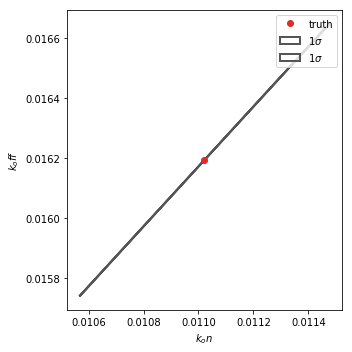

In [23]:
from  matplotlib.patches  import Ellipse

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,1]:
    ax.add_patch(Ellipse(pars, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax.plot(kon_fit, koff_fit, marker='o', zorder=10, linestyle='none',
        color='#de2d26', label='truth')

ax.set_xlabel('$k_on$')
ax.set_ylabel('$k_off$')
ax.legend(loc='best')

fig.tight_layout()

In [93]:
# Now create a loop to fit our MS2 Loop Construct to a range of parameters to test our inference.
# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=4;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on_range = np.linspace(start=0.001, stop=0.08, num=10)
# keep kon constant for the time being
#k_on_range = np.ones(10) * 0.016
k_off_range = np.linspace(start=0.02, stop=0.14, num=10)

ksum_true = np.linspace(start=0.001, stop=0.15, num=10)

duration = 500   # seconds
num = 200           # number of traces in each simulated dataset

pon = 0.4        # set pon to test inference

loop_function = SnailPromoterMs2Loops().loop_function


In [94]:
ksum_true

array([0.001     , 0.01755556, 0.03411111, 0.05066667, 0.06722222,
       0.08377778, 0.10033333, 0.11688889, 0.13344444, 0.15      ])

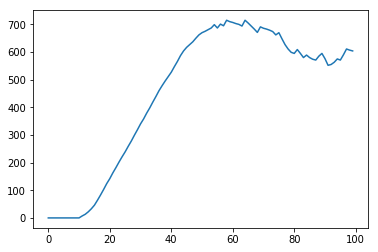

In [95]:
plt.plot(tracePackage.tracelist[2])

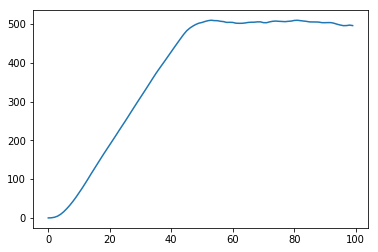

In [96]:
tracePackage = tracePackageSimulation(num, 0.027, 0.04, duration, stepsize, loop_function, k_elong, tPol)
plt.plot(np.mean(tracePackage.tracelist, axis=0))

In [97]:
start_index = 42
stop_index = -1

In [98]:
pon

0.4

In [99]:
# create a new simulated trace package for each kon, koff to test inference
ksum_fit_list = []
kon_fit_list = []
koff_fit_list = []
for k in range(len(ksum_true)):
    # calculate kon and koff
    
    kon=ksum_true[k]*pon
    koff=ksum_true[k]*(1-pon)
    
    # simulated trace package
    tracePackage = tracePackageSimulation(num, kon, koff, duration, stepsize, loop_function, k_elong, tPol)
    # compute autocorrelation attributes
    autopackage = tracePackageAutocorrelation(tracePackage.tracelist, loop_function, start_index, stop_index)
    # create the fitting object
    fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)
    # fit function with a constant pon and store pars
    kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=False, 
                                                                                   upperbound=0.3, lowerbound=0.0005, fitpon=True)

    kon_fit_list.append(kon_fit)
    koff_fit_list.append(koff_fit)    
    ksum_fit_list.append(1/chrtime)
    

In [100]:
ksum_fit_list

[0.028494933015815464,
 0.028072382677627742,
 0.026101480951130917,
 0.028974055683442617,
 0.025127241538371335,
 0.02522425505192496,
 0.023637836668597,
 0.023317258725091834,
 0.022466663458571325,
 0.02422951480328482]

In [101]:
np.asarray(ksum_fit_list),ksum_true

(array([0.02849493, 0.02807238, 0.02610148, 0.02897406, 0.02512724,
        0.02522426, 0.02363784, 0.02331726, 0.02246666, 0.02422951]),
 array([0.001     , 0.01755556, 0.03411111, 0.05066667, 0.06722222,
        0.08377778, 0.10033333, 0.11688889, 0.13344444, 0.15      ]))

In [102]:
ksum_fit_list = np.asarray(ksum_fit_list)
ksum_fit_list[0] = 0

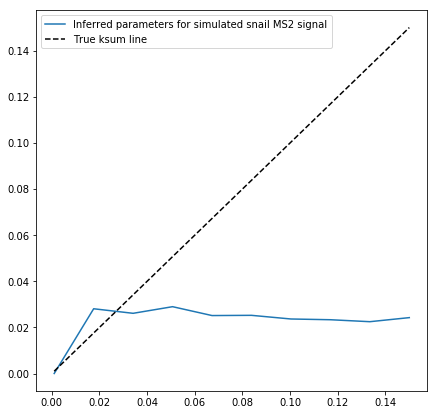

In [103]:
# Now plot the inferred parameters against the true inputs
fig,ax = plt.subplots(1, 1, figsize=(7,7), sharex=True)

ax.plot(ksum_true, np.asarray(ksum_fit_list), label='Inferred parameters for simulated snail MS2 signal')
ax.plot(ksum_true, ksum_true, '--', color='k', label='True ksum line')
#ax.set_xlim(0,0.15)
#ax.set_ylim(0,0.15)
plt.legend(loc='best')
plt.show()
#for i in autolist[1:]: